<a href="https://colab.research.google.com/github/srujanreddy09/Natural_Language_Processing/blob/master/Reuters_Newswire_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Modules**

In [ ]:
import numpy as np
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, AUC
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Helper Functions**

In [ ]:
# For plotting accuracy during training phase
def accuracy_plotter(history):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.clf()

# For plotting loss during training phase
def loss_plotter(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    plt.clf()

In [ ]:
# Parameters
nb_epochs = 25
num_words = 10000
common_words = 10
nb_classes = 46

## **Loading Data**

In [ ]:
# Choosing the top 10000 frequent words and skipping the top 15 common words 
(data, targets) = reuters.load_data(num_words=num_words, skip_top=common_words, test_split=0)[0]

## **Data Analysis**

In [ ]:
print("Shape of the data :", data.shape)

Shape of the data : (11228,)


In [ ]:
print("Categories of the targets: ", np.unique(targets))

Categories of the targets:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


In [ ]:
print("Number of unique words :", len(np.unique(np.hstack(data))))

Number of unique words : 9991


In [ ]:
print("Average length of a sentence", np.mean([len(i) for i in data]))

Average length of a sentence 145.96419665122906


In [ ]:
print("Max length of a sentence : ", np.max([len(i) for i in data]))

Max length of a sentence :  2376


In [ ]:
# Retrieving the word_index dictionary
word_dict = {value:key for (key, value) in reuters.get_word_index().items()}

In [ ]:
# An example newswire
print(' '.join([word_dict[x] for x in data[22]]))
print(targets[22])

of of profit of 1 75 of not concern government member be name incorporation profits on tonnes of this oper 10 of commodities of reserve not whether profits on tonnes of of of council gross of yields finance its all also is of sources 4 is of an source of of this rose billion trade vs 000 of this of of commodities or of agreement of around against should with shareholders total 000 april 0 of oper 10 conference of of pct dlrs
4


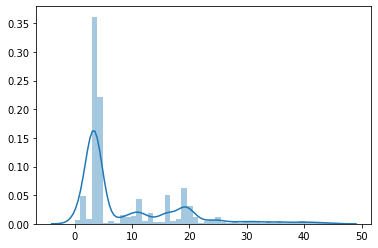

In [ ]:
#Check if the data is imbalanced
sns.distplot(targets)

The data is imbalanced as the number of examples belonging to one class are much larger that of the other classes. Accuracy is not a good measure to evaluate our model. Instead Precision_Recall-AUC will help us better understand the performance of our model. A high AUC represents both high recall and high precision which shows that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).
To balance the data, we are going to provide some bias to the mminority class. This is better than upsampling the minority classes because we have a large number of classes.

## **Data Preprocessing**

In [ ]:
# Splitting into train and test data
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.3, random_state=42)

In [ ]:
# Tokenizing the sequences
tokenizer = Tokenizer(num_words=num_words, oov_token="oov_tok")
tokenizer.fit_on_sequences(x_train)
word_index = tokenizer.word_index

In [ ]:
# Fitting the sequences on the tokenizer
train_sequences = tokenizer.sequences_to_matrix(x_train, mode = "binary")
test_sequences = tokenizer.sequences_to_matrix(x_test, mode = "binary")

In [ ]:
print("Shape of vectorized sequences :", train_sequences.shape)
print("Shape of targets :", y_train.shape)

Shape of vectorized sequences : (7859, 10000)
Shape of targets : (7859,)


## **Computing class_weights**

In [ ]:
weights = class_weight.compute_class_weight("balanced", np.unique(y_train), y_train)
class_weights = dict(enumerate(weights))

In [ ]:
# One hot encoding targets
train_labels = to_categorical(y_train, num_classes = nb_classes)
test_labels = to_categorical(y_test, num_classes = nb_classes)

## **Model Architecture**

In [ ]:
model = Sequential()
model.add(Dense(64, activation = "relu", input_shape = (num_words,)))
model.add(Dropout(0.3))
model.add(Dense(32, activation = "relu",))
model.add(Dropout(0.3))
model.add(Dense(nb_classes, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                1518      
Total params: 643,662
Trainable params: 643,662
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[CategoricalAccuracy(name="categorical_accuracy")])

In [ ]:
# Early Stopping 
early_stop = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

In [ ]:
history = model.fit(train_sequences, train_labels, validation_split=0.3, shuffle=True, epochs = nb_epochs, callbacks=[early_stop], class_weight = class_weights)

Epoch 1/25
172/172 [==============================] - 1s 8ms/step - loss: 3.6908 - categorical_accuracy: 0.3225 - val_loss: 2.6270 - val_categorical_accuracy: 0.6277
Epoch 2/25
172/172 [==============================] - 1s 7ms/step - loss: 3.0779 - categorical_accuracy: 0.5515 - val_loss: 2.0248 - val_categorical_accuracy: 0.7023
Epoch 3/25
172/172 [==============================] - 1s 7ms/step - loss: 2.3661 - categorical_accuracy: 0.5704 - val_loss: 1.7199 - val_categorical_accuracy: 0.7239
Epoch 4/25
172/172 [==============================] - 1s 7ms/step - loss: 1.7337 - categorical_accuracy: 0.6035 - val_loss: 1.3752 - val_categorical_accuracy: 0.7519
Epoch 5/25
172/172 [==============================] - 1s 7ms/step - loss: 1.3922 - categorical_accuracy: 0.6341 - val_loss: 1.2859 - val_categorical_accuracy: 0.7578
Epoch 6/25
172/172 [==============================] - 1s 7ms/step - loss: 1.1733 - categorical_accuracy: 0.6602 - val_loss: 1.3089 - val_categorical_accuracy: 0.7455
Epoc

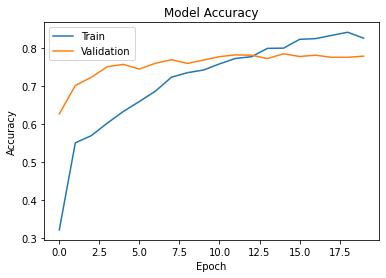

<Figure size 432x288 with 0 Axes>

In [ ]:
# Accuracy values during training phase 
accuracy_plotter(history)

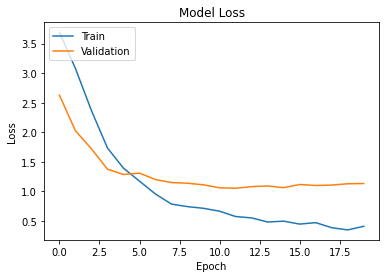

<Figure size 432x288 with 0 Axes>

In [ ]:
# Loss values during training phase
loss_plotter(history)

In [ ]:
y_pred = model.predict(test_sequences)

In [ ]:
precision = Precision()
recall = Recall()
auc = AUC(curve = "PR")
precision.update_state(test_labels, y_pred)
recall.update_state(test_labels, y_pred)
auc.update_state(test_labels, y_pred)

In [ ]:
_, acc = model.evaluate(test_sequences, test_labels)
print("Accuracy on test set :", round(acc*100, 3))
print("Precision :", precision.result().numpy())
print("Recall :", recall.result().numpy())
print("Precision-Recall_AUC :", auc.result().numpy())

106/106 [==============================] - 0s 2ms/step - loss: 1.0777 - categorical_accuracy: 0.7869
Accuracy on test set : 78.688
Precision : 0.852199
Recall : 0.7016919
Precision-Recall_AUC : 0.78282315
